## Demonstration of NeuralNet module 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import NeuralNet as student

## Demonstrating this on a simple 1D scalar function $y=x^2$

In [2]:
def x_batch(batch_size):
    return np.random.rand(batch_size,1)-0.5
def y_batch(x):
    return np.power(x,2)

In [3]:
x_train = x_batch(32*10000)
y_train = y_batch(x_train)

In [4]:
model = student.Model(architecture=[1,32,32,1],loss='power',softmax=False)

W0422 09:34:42.597988 4550757824 deprecation.py:323] From /Users/utkarsh/venv/lib/python3.6/site-packages/tensorflow_core/python/ops/math_grad.py:1375: where (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [5]:
history = model.train(x_train,y_train)

epoch: 1
training: 99 %   loss: 3.9797101127261234e-07  lr: 0.001                                                                                                               


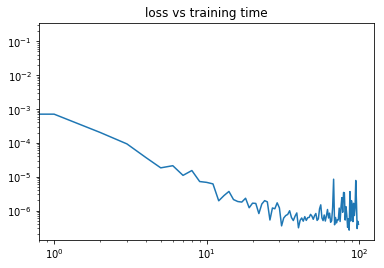

In [6]:
plt.loglog(history['loss history'])
plt.title('loss vs training time')
plt.show()

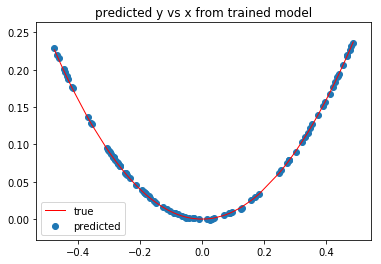

In [7]:
#plotting the predicted function:
x_test = x_batch(100)
y_pred = model.predict(x_test)
plt.scatter(x_test,y_pred,label='predicted')
plt.plot(np.sort(x_test.flatten()),np.sort(x_test.flatten())**2, 'r', linewidth=1, label='true')
plt.title('predicted y vs x from trained model')
plt.legend()
plt.show()

### further training the same model. 
The model stores training histories from all training sessions in the global variable ```history```, and the consolidated loss history is in ```loss_history```

In [8]:
x_train = x_batch(32*20000)
y_train = y_batch(x_train)
history = model.train(x_train,y_train)

epoch: 1
training: 99 %   loss: 3.993010835824591e-07  lr: 0.001                                                                                                                


In [9]:
print('model history keys:\n', model.history.keys())
print('training session 1 keys:\n', model.history['training session 1'].keys())

model history keys:
 dict_keys(['training session 1', 'training session 2'])
training session 1 keys:
 dict_keys(['epoch1', 'start time', 'loss history', 'loss history step size', 'end time', 'asymptotic loss'])


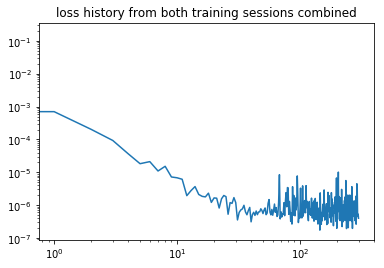

In [10]:
plt.loglog(model.loss_history)
plt.title('loss history from both training sessions combined')
plt.show()

## Demonstrating MNIST using this module

In [11]:
from tensorflow.keras import datasets

(train_images, train_labels), (test_images, test_labels) = datasets.mnist.load_data()
# Normalize pixel values to be between 0 and 1
train_images, test_images = train_images / 255.0, test_images / 255.0

In [12]:
#Reshape the arrays into shape [batch_size,28**2] for images, and [batch_size,10] for labels
train_images = train_images.reshape((len(train_images),28*28))
test_images = test_images.reshape((len(test_images),28*28))

z = np.zeros((len(train_labels), 10))
z[np.arange(len(train_labels)),train_labels] = 1
train_labels = z


In [13]:
#By default softmax=True, loss='KL', so we don't need to specify that explicitly unlike in the previous case
model = student.Model(architecture=[28*28,200,200,10])

In [14]:
history = model.train(train_images,train_labels,epochs=2)

epoch: 1
training: 96 %   loss: 0.14637760818004608  lr: 0.001                                                                                                               
epoch: 2
training: 96 %   loss: 0.05737805739045143  lr: 0.001                                                                                                                


In [15]:
y_pred = np.argmax(model.predict(test_images),axis=1)
accuracy = np.sum(np.equal(y_pred,test_labels))/len(test_labels)
print('accuracy:',accuracy*100,'%')

accuracy: 96.84 %


## Demonstrating teacher module

In [16]:
import numpy as np
import os
import matplotlib.pyplot as plt
import teacher

In [17]:
# This generates a random teacher with the specified architecture:
t = teacher.Teacher(architecture=[4,64,64,64,2])

# This generates a random teacher with the specified architecture, and any input is first pre-multiplied by the weights in 'scale'.
# In this example, the first three inputs pass onto the layers as it is, but the last input slot just gets zero
# We use scale to set the number of features
t = teacher.Teacher(architecture=[4,64,64,64,2],scale=[1,1,1,0])

### teacher inputs/outputs can be saved in a hdf5 file (inputs are randomly generated)
This database can be generated with the option create_database=True. The default location is ```database_dir='/dev/tmp'```.

The default file name is 'data3.h5' for the case above ( 'data<sum(scale)>.h5' in general). Default file size is $8* 10^6$ datapoints.

with option reduce, the number of datapoints can controlled (increase or decrease)  $\left(= \frac{8* 10^6}{\text{reduce}}\right)$

In [18]:
#create database in current directory with 8*10**3 daatpoints
os.mkdir('./database')
t = teacher.Teacher(architecture=[4,64,64,64,2],scale=[1,1,1,0],create_database=True,reduce=1000,database_dir='./database')

In [19]:
# load W and b from database folder
W = teacher.load_weights(folder='./database',file='W.csv')
b = teacher.load_weights(folder='./database',file='b.csv')

# load from database. Not necessary to feed W and b (just feed architecture). But then can't rely on the predict method since it uses W and b
t = teacher.Teacher(W=W,b=b,scale=[1,1,1,0],use_database=True,database_dir='./database')

database loaded.                       used: 4 G                   73 %   memory total: 8 G  used: 4 G                   


use_database=True loads the data into numpy arrays ```data_matrix_x``` and ```data_matrix_y```, and the method ```predict_from_matrix``` returns x and y from the data matrices

In [20]:
x,y = t.predict_from_matrix(batch_size=10)

#### To create database for MSE loss, use softmax=False in the init arguments of Teacher. 

e.g. To create a database with $8*10^3$ datapoints for MSE, with a teacher of architecture $[8,64,64,1]$ and $6$ features, run the following: 

In [21]:
os.mkdir('./database')
t = teacher.Teacher(architecture=[8,64,64,1],scale=[1,1,1,1,1,1,0,0],create_database=True,reduce=1000,database_dir='./database',softmax=False)